In [1]:
# Libraries
import open3d as o3d
import viser
import torch
import numpy as np
import cv2

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
#@title Importing the Clusters with It's radiances
slices = torch.load("/workspace/FruitProposal/attachment/RadianceCloud/slice_points.pt")
print(slices.keys())

planes  = slices['plane']
points  = slices['points']
rgbs    = slices['rgb']
centers = slices['slice_center']
corners = slices['slice_corner']

print(planes.shape, points.shape, rgbs.shape, centers.shape, corners.shape)
print(planes[0], points[0], rgbs[0], centers[0], corners[0])

dict_keys(['points', 'plane', 'rgb', 'slice_corner', 'slice_center'])
(9,) (9,) (9,) (9, 3) (9, 4, 3)
[[ 0.2777112   0.21965742 -0.0116659 ]
 [ 0.27800527  0.22003262 -0.0116659 ]
 [ 0.2591268   0.21109611 -0.0116659 ]
 [ 0.2779954   0.21947724 -0.0116659 ]
 [ 0.2784992   0.21941476 -0.0116659 ]
 [ 0.27876925  0.2193357  -0.0116659 ]
 [ 0.28082907  0.21845505 -0.0116659 ]
 [ 0.27920464  0.21951577 -0.0116659 ]
 [ 0.2780647   0.21993083 -0.0116659 ]
 [ 0.2777782   0.2200255  -0.0116659 ]
 [ 0.27898696  0.21870169 -0.0116659 ]
 [ 0.2792523   0.218939   -0.0116659 ]
 [ 0.27881837  0.21881194 -0.0116659 ]
 [ 0.28017086  0.21802598 -0.0116659 ]
 [ 0.27835977  0.2201727  -0.0116659 ]
 [ 0.2792223   0.2185429  -0.0116659 ]
 [ 0.2578007   0.18962431 -0.0116659 ]
 [ 0.28058594  0.21809    -0.0116659 ]
 [ 0.28012165  0.21901882 -0.0116659 ]
 [ 0.28036568  0.21846569 -0.0116659 ]
 [ 0.27955678  0.2186509  -0.0116659 ]
 [ 0.27956325  0.21870366 -0.0116659 ]] [[ 0.2777112   0.21965742 -0.0116659 ]


In [3]:
# Forzamos z=1
_planes = [plane.copy() for plane in planes]
for plane in _planes:
    plane[:,2] = 1.0
_centers  = centers.copy();  _centers[:,2]  = 1.0

_corners  = [c.copy() for c in corners]
for c in _corners:
    c[:,2] = 1.0

In [4]:
# 1) Calcular R solo una vez (misma orientación para todas)
z_cam    = np.array([0,0,-1], dtype=np.float32)
e        = _corners[0][0] - _corners[0][1]
e_norm   = np.linalg.norm(e)
y_cam    = e / e_norm
x_cam    = np.cross(y_cam, z_cam); x_cam /= np.linalg.norm(x_cam)
y_cam    = np.cross(z_cam, x_cam); y_cam /= np.linalg.norm(y_cam)
R        = np.column_stack((x_cam, y_cam, z_cam))
print("R\n", R)


R
 [[-0. -1.  0.]
 [-1.  0.  0.]
 [-0.  0. -1.]]


In [5]:
# 2) Intrínsecos
W = H = 512
cx = cy = W/2
fxy      = W
intrinsic = np.array([
    [fxy,   0, cx],
    [  0, fxy, cy],
    [  0,   0,  1]
], dtype=np.float32)
print("Intrinsic\n", intrinsic)

Intrinsic
 [[512.   0. 256.]
 [  0. 512. 256.]
 [  0.   0.   1.]]


In [ ]:
# 3) Bucle por cada slice
for k, (plane_k, rgb_k, center_k) in enumerate(
        zip(_planes, rgbs, _centers)):

    # Renderizar slice
    void_image = np.zeros((H, W, 3), dtype=np.uint8)

    # Posición inicial de la cámara sobre el centro del slice
    C = center_k + np.array([0,0,e_norm], dtype=np.float32)
    t = -R @ C

    for pt, color in zip(plane_k, rgb_k):

        Xc = R @ pt.T + t
        uvw = intrinsic @ Xc
        u, v = uvw[0]/uvw[2], uvw[1]/uvw[2]

        ui, vi = int(round(u)), int(round(v))
        if 0 <= ui < W and 0 <= vi < H:
            void_image[vi, ui] = color * 255

    mask = (np.any(void_image > 0, axis=2)).astype(np.uint8) * 255

    # 3.4) Dilatación y guardado
    kernel = np.ones((3,3), np.uint8)
    dilated_rgb = cv2.dilate(void_image, kernel, iterations=5)
    dilated_mask = cv2.dilate(mask, kernel, iterations=5)
    
    bgra = np.dstack([
        dilated_rgb[..., 2],
        dilated_rgb[..., 1],
        dilated_rgb[..., 0],
        dilated_mask        
    ]) 

    out    = cv2.dilate(cv2.cvtColor(void_image, cv2.COLOR_RGB2BGR), kernel, iterations=5)
    cv2.imwrite(f"/workspace/FruitProposal/attachment/RadianceCloud/images/slice_{k}.png", out)
    out_hsv    = cv2.dilate(cv2.cvtColor(void_image, cv2.COLOR_RGB2HSV), kernel, iterations=5)
    cv2.imwrite(f"/workspace/FruitProposal/attachment/RadianceCloud/images/slice_hsv_{k}.png", out_hsv)
    # Save a transparent version
    cv2.imwrite(f"/workspace/FruitProposal/attachment/RadianceCloud/images/slice_transparent_{k}.png", bgra)

    

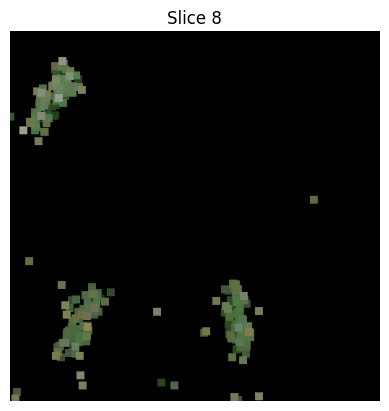

In [7]:
from matplotlib import pyplot as plt
# Visualizar el último slice
plt.imshow(cv2.dilate(void_image, kernel, iterations=5))
plt.axis('off')
plt.title(f"Slice {k}")
plt.show()